For NN:

GPU run mode:

```
THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 ipython notebook
```

CPU run mode:

```
THEANO_FLAGS=mode=FAST_RUN,device=cpu,floatX=float32 ipython notebook
```

To use Theano you need NVIDIA GPUs, hence won't work on some Macbook Pros.

In [8]:
%autosave 10

import re

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.models import model_from_json
from keras.regularizers import l2, l1l2, activity_l1l2
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History, EarlyStopping

import numpy as np
import pandas as pd

Autosaving every 10 seconds


## important, check

you must see `Using gpu device 0: GRID K520 (CNMeM is disabled)` above, or else you're not using the GPU for NN training. the first time you run theano it may take 1-2 minutes to see this message, be patient.

Let's assume I forgot to package a certain Python module and I desperately want it without SSH'ing to the master. I can do:

In [2]:
!/home/ubuntu/miniconda/bin/conda install -y nltk

# if not found by conda, use pip
# !/home/ubuntu/miniconda/bin/pip install my-module

Fetching package metadata: ....
Solving package specifications: .....................
Package plan for installation in environment /home/ubuntu/miniconda:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    nltk-3.1                   |           py27_0         1.7 MB

The following NEW packages will be INSTALLED:

    nltk: 3.1-py27_0

Fetching packages ...
nltk-3.1-py27_ 100% |################################| Time: 0:00:01   1.41 MB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|###################################################| 100%


In [3]:
from nltk.stem.snowball import SnowballStemmer

## Preprocess data

In [4]:
all_train_filepath = "/mnt/kaggle-whats-cooking/train.json"
all_train = pd.read_json(all_train_filepath)
X_all_train = all_train["ingredients"]
y_all_train = all_train["cuisine"]

In [5]:
cuisine_encoder = LabelEncoder()
cuisine_encoder.fit(y_all_train)
y_all_train_encoded = cuisine_encoder.transform(y_all_train)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all_train, y_all_train_encoded, train_size=0.8, random_state=42,
    stratify=y_all_train)

In [7]:
stemmer = SnowballStemmer("english")

def process_ingredients(x):
    """scikit-learn requires a list of strings as the output of the
    tokenizer. However we already start with a list of strings
    (normally problems start with a plain string)."""
    all_ingredients = []
    for i in xrange(len(x)):
        x[i] = re.sub('\([^)]+\)\s*', '', x[i]) #  remove brackets
        x[i] = re.sub('[^\\%]+\\%\s*', '', x[i]) #  remove percent signs
        x[i] = x[i].strip().lower()  # lower case, trim
        x[i] = stemmer.stem(x[i])  #  reduce ingredient to its stem, minor accuracy improvement
        result = [x[i]] + x[i].split(' ')
        for j in xrange(len(result)):
            result[j] = result[j].strip().lower()
            result[j] = re.sub('[^a-z]', ' ', result[j])
        for ingredient in result:
            if len(ingredient.strip()) != 0:
                all_ingredients.append(ingredient)
    return all_ingredients

X_train_vectorizer = CountVectorizer(min_df=1, binary=True,
                                     tokenizer=process_ingredients,
                                     lowercase=False,
                                     ngram_range=(1, 2),
                                     dtype=np.uint8)

# does significantly worse than just using counts
#X_train_vectorizer = TfidfVectorizer(min_df=1, binary=True,
#                                     tokenizer=process_ingredients,
#                                     lowercase=False,
#                                     ngram_range=(1, 2))

# we have around 1 million features. you can use the hashing trick to
# vectorize to a smaller number of features without losing too much
# information. could be an interesting step to take before deep
# neural network trainining (reduce the number of features to allow
# larger and more complex models to fit in the GPU's memory). however
# this is pointless for SGDClassifier (i.e. logistic regression) because
# we can fit the counts as a sparse matrix in memory, and we don't mind
# how long it takes to train the model.
#X_train_vectorizer = HashingVectorizer(binary=True,
#                                       tokenizer=process_ingredients,
#                                       lowercase=False,
#                                       ngram_range=(1, 2),
#                                       n_features=500000)

X_train_tf = X_train_vectorizer.fit_transform(X_train)

## Linear classifiers

In [8]:
param_grid = {
    'alpha': [0.0001],  # regularization, penalizes large coefficients
    'l1_ratio': np.linspace(0, 0.5, num=10),  # elastic net param. 0 is L2, 1 is L1
    'n_iter': [5],
    'penalty': ['elasticnet'],
    'loss': ['log'],
}
model = SGDClassifier(random_state=42, n_jobs=-1)

cv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.1,
                            random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
grid.fit(X_train_tf, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(labels=[7 9 ..., 1 7], n_iter=10, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['elasticnet'], 'alpha': [0.0001], 'n_iter': [5], 'loss': ['log'], 'l1_ratio': array([ 0.     ,  0.05556,  0.11111,  0.16667,  0.22222,  0.27778,
        0.33333,  0.38889,  0.44444,  0.5    ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [9]:
grid.best_params_

{'alpha': 0.0001,
 'l1_ratio': 0.1111111111111111,
 'loss': 'log',
 'n_iter': 5,
 'penalty': 'elasticnet'}

In [10]:
X_test_tf = X_train_vectorizer.transform(X_test)
y_test_pred = grid.predict(X_test_tf)

In [11]:
score = accuracy_score(y_test, y_test_pred)
print(score)

0.778280542986


## Submit linear classifier

In [12]:
submission_filepath = "/mnt/kaggle-whats-cooking/test.json"
submission = pd.read_json(submission_filepath)
X_submission = submission["ingredients"]
X_submission_df = X_train_vectorizer.transform(X_submission)
y_submission = grid.predict(X_submission_df)
y_cuisine = cuisine_encoder.inverse_transform(y_submission)
df = pd.DataFrame({"cuisine": y_cuisine}, index=submission["id"])

In [13]:
df.to_csv("submission.csv")

## Neural networks

See:

- http://nbviewer.ipython.org/github/Egor-Krivov/cooking/blob/master/kaggle.ipynb
- https://github.com/Egor-Krivov/cooking/blob/master/utils.py
- https://github.com/fchollet/keras/blob/master/examples/kaggle_otto_nn.py
- http://cs231n.github.io/

Papers:

- http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf

Here's a way to check if you're successfully using the GPU, or falling back to the CPU

In [9]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in xrange(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.663414 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [10]:
np.random.seed(42)

In [11]:
y_train_hot_encoded = np.array(
    np.zeros((y_train.shape[0], len(cuisine_encoder.classes_))),
    dtype=np.int8)
for i, value in enumerate(y_train):
    y_train_hot_encoded[i, value] = 1

First we compile the model and load it onto the GPU. This takes a few minutes. If you get a memory error restart the kernel and try again.

In [16]:
input_dropout = 0.75
dropout = 0.75
l1 = 0
l2 = 0
layers = [1024, 1024]

model = Sequential()
model.add(Dropout(input_dropout, input_shape=(X_train_tf.shape[1], )))  # regularize inputs
for layer in layers:
    model.add(Dense(layer, W_regularizer=l1l2(l1, l2)))

    # choose an activation
    model.add(Activation('relu'))  # the default activation to try first
    #model.add(PReLU())

    #model.add(BatchNormalization())  # makes it worse
    model.add(Dropout(dropout))  # regularization, 0.5 is a good default dropout rate
model.add(Dense(y_train_hot_encoded.shape[1], W_regularizer=l1l2(l1, l2)))
model.add(Activation('softmax'))

# optimizers.
# adam is much faster. i think too fast, need to slow down learning rate from default.
# sgd is more optimal (i think). lr 0.1 seems a bit slow, but the default is 0.01!
sgd = SGD(lr=0.2, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam()

model.compile(loss='categorical_crossentropy', optimizer=sgd)
model_description = model.to_json()

Here is where we train. You can still abort the notebook here, but you'll probably have to restart the kernel and reload the data. Note that when you want to re-run this if you get memory errors you need to restart the kernel and reload the data.

Also note that if you interrupt the kernel and restart training it doesn't start from scratch. Restarting the kernel will of course start everything from scratch.

In [17]:
nb_epoch = 100

# make this as large as possible without running out of memory
# (i think! you should play around with this and see what your results are)
# on kaggle people seem to use 16-128, but to get fast results use 1024+. 4096 runs out of memory.
batch_size = 2048

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')

history = model.fit(
    X_train_tf.todense(),
    y_train_hot_encoded,
    nb_epoch=nb_epoch,
    batch_size=batch_size,
    show_accuracy=True,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Train on 28636 samples, validate on 3182 samples
Epoch 1/100
28636/28636 [==============================] - 26s - loss: 2.5530 - acc: 0.2628 - val_loss: 2.0230 - val_acc: 0.4730
Epoch 2/100
28636/28636 [==============================] - 27s - loss: 1.9741 - acc: 0.4494 - val_loss: 1.5302 - val_acc: 0.5569
Epoch 3/100
28636/28636 [==============================] - 27s - loss: 1.7101 - acc: 0.5069 - val_loss: 1.3413 - val_acc: 0.6072
Epoch 4/100
28636/28636 [==============================] - 27s - loss: 1.5840 - acc: 0.5364 - val_loss: 1.2602 - val_acc: 0.6464
Epoch 5/100
28636/28636 [==============================] - 27s - loss: 1.5131 - acc: 0.5539 - val_loss: 1.1952 - val_acc: 0.6615
Epoch 6/100
28636/28636 [==============================] - 27s - loss: 1.4627 - acc: 0.5651 - val_loss: 1.1669 - val_acc: 0.6725
Epoch 7/100
28636/28636 [==============================] - 26s - loss: 1.4224 - acc: 0.5793 - val_loss: 1.1328 - val_acc: 0.6807
Epoch 8/100
28636/28636 [=======================

Draw history of accuracies during training to see if we're overfitting or underfitting. In keras plotting loss is very misleading because we train on the regularized model using dropout, but we test without dropout. Hence validation loss is always smaller than training loss, and hard to interpret.

Then again I've noticed that validation accuracy is usually higher than train accuracy, which doesn't make sense...

In [24]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

class EpochDrawer(object):
    '''
    takes the history of keras.models.Sequential().fit() and
    plots training and validation accuracy over the epochs
    '''
    def __init__(self, history, key='acc', save_filename = None):

        self.x = history.epoch
        self.legend = [key]

        plt.plot(self.x, history.history[key], marker='.')

        if 'val_%s' % key in history.history:
            self.legend.append('val %s' % key)
            plt.plot(self.x, history.history['val_%s' % key], marker='.')

        plt.title('%s over epochs' % key)
        plt.xlabel('Epochs')
        plt.xticks(history.epoch, history.epoch)
        plt.legend(self.legend, loc = 'lower right')

        if save_filename is not None:
            plt.savefig(save_filename)

        plt.show()

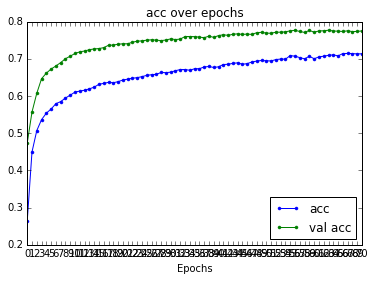

In [25]:
EpochDrawer(history)
pass

Remember - the smaller the gap between the curves the higher the bias. Small gap => try more complex, big gap => you need to regularize more.

In this case I don't really know if we're high bias or high variance. Needs more experimentation!

In [20]:
X_test_tf = X_train_vectorizer.transform(X_test)
y_test_pred = model.predict_classes(X_test_tf.todense(), batch_size=batch_size)

7956/7956 [==============================] - 5s     


In [21]:
score = accuracy_score(y_test, y_test_pred)
print(score)

0.79009552539


## Submit NN

In [22]:
submission_filepath = "/mnt/kaggle-whats-cooking/test.json"
submission = pd.read_json(submission_filepath)
X_submission = submission["ingredients"]
X_submission_df = X_train_vectorizer.transform(X_submission)
y_submission = model.predict_classes(X_submission_df.todense(), batch_size=batch_size)
y_cuisine = cuisine_encoder.inverse_transform(y_submission)
df = pd.DataFrame({"cuisine": y_cuisine}, index=submission["id"])

9944/9944 [==============================] - 6s     


In [23]:
df.to_csv("submission_nn.csv")

## TODO - ensemble NN and logistic regression?